In [1]:
pip install pyod shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 7.7 MB/s 
     |████████████████████████████████| 575 kB 58.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=530cba334f1469b47ef9c4d81684064be7232825ecbb29233f3fee1b95194deb
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.lof import LOF
import matplotlib.pyplot as plt
import seaborn as sn
import shap
from pickle import dump, load

#### Data Loading

In [3]:
df=pd.read_pickle('https://drive.google.com/uc?id=1hILz_vBupbUaEICj_Xgw933g5Har2hpW')

In [4]:
df.head()

,IDATE,LAT,LON,ELEVATION_m,PPT_mm,TMIN_c,TMEAN_c,TMAX_c,TDMEAN_c,lfmc_mean,lfmc_stdv,Mean_Sea_Level_Pressure,Mean_Station_Pressure,Mean_Wind_Speed,Maximum_Sustained_Wind_Speed,VPDMIN_hpa,VPDMAX_hpa
0,0.026572,0.256588,0.611242,0.252408,0.0,0.307359,0.377970,0.439271,0.350840,0.183593,0.234687,0.398496,0.917252,0.147619,0.200000,0.106533,0.234453
1,0.026572,0.306701,0.553827,0.267139,0.0,0.411255,0.431965,0.443320,0.487395,0.015900,0.099077,0.416040,0.913973,0.114286,0.211321,0.116937,0.207287
2,0.088574,0.177170,0.686698,0.265439,0.0,0.409091,0.460043,0.497976,0.449580,0.583804,0.335023,0.478697,0.928806,0.161905,0.290566,0.166875,0.245912
3,0.090345,0.650015,0.374516,0.460907,0.0,0.283550,0.280778,0.281377,0.279412,0.352868,0.308407,0.443609,0.790320,0.157143,0.222642,0.081149,0.144586
4,0.091231,0.113036,0.775809,0.553258,0.0,0.270563,0.269978,0.269231,0.250000,0.405914,0.409989,0.433584,0.953630,0.171429,0.211321,0.097794,0.118965


In [5]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=False)
#Labels for PyOD 0 = inlier, 1 = outlier 
y_train=np.zeros(X_train.shape[0])
y_test=np.zeros(X_test.shape[0])
print("Train set data size : "+str(X_train.shape))
print("Test set data size : "+str(X_test.shape))

Train set data size : (5868, 17)
Test set data size : (1467, 17)


#### Model Training

In [6]:
estimator=DeepSVDD(c=None, random_state=1, hidden_neurons=[32,32,16])
estimator.fit(X_train)

184/184 [==============================] - 1s 1ms/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 32)                1024      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 net_output (Dense)          (None, 16)                512       
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 16)               0         
 bda)                                                            
    

DeepSVDD(batch_size=32,
     c=array([0.21275, 0.1    , 0.1    , 0.28714, 0.1    , 0.14324, 0.22389,
       0.1    , 0.42763, 0.1    , 0.1    , 0.18797, 0.2394 , 0.27059,
       0.57672, 0.1    ], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=100,
     hidden_activation='relu', hidden_neurons=[32, 32, 16],
     l2_regularizer=0.1, optimizer='adam', output_activation='sigmoid',
     preprocessing=True, random_state=1, use_ae=False, validation_size=0.1,
     verbose=1)

In [7]:
dump(estimator, open('09_CA_DeepSVDD.pkl', 'wb'))
#Consider univercity full shap version
#Below probabilities have changed there

#### Train set AVG Probability of Being Inlier

In [8]:
P1=estimator.predict_proba(X_train)[:,0]
print("Training set Mean :  ",round(np.mean(P1),6))
print("Training set STD :  ",round(np.std(P1),6))

184/184 [==============================] - 0s 1ms/step
Training set Mean :   0.959025
Training set STD :   0.061362


#### Test set AVG Probability of Being Inlier

In [9]:
P2=estimator.predict_proba(X_test)[:,0]
print("Test set Mean :  ",round(np.mean(P2),6))
print("Test set STD :  ",round(np.std(P2),6))

46/46 [==============================] - 0s 1ms/step
Test set Mean :   0.959791
Test set STD :   0.04975


#### All set AVG Probability of Being Inlier

In [10]:
P=np.append(P1,P2)
print("All Mean :  ",round(np.mean(P),6))
print("All STD :  ",round(np.std(P),6))

All Mean :   0.959178
All STD :   0.059223


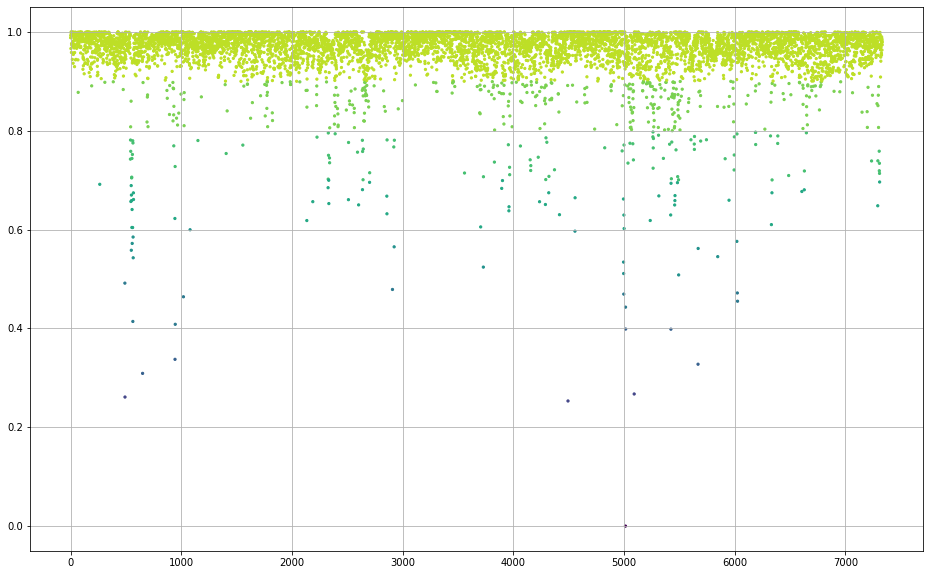

In [11]:
fig, ax = plt.subplots(figsize=(16,10))
im=ax.scatter(x=df.index,y=P,c=np.multiply(P,10).astype(int),s=5)
ax.grid(True)
plt.show()

In [12]:
#estimator.explain_outlier(1000)

#### Feature Importance

In [ ]:
warnings.filterwarnings('ignore')
#k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1))
k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, nsamples=500, random_state=1))
X_test_sample=shap.sample(X_test,random_state=1)
k_shap_values = k_explainer.shap_values(X_test_sample) # More Sample Need more time
warnings.filterwarnings('once')

16/16 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

32532/32532 [==============================] - 38s 1ms/step


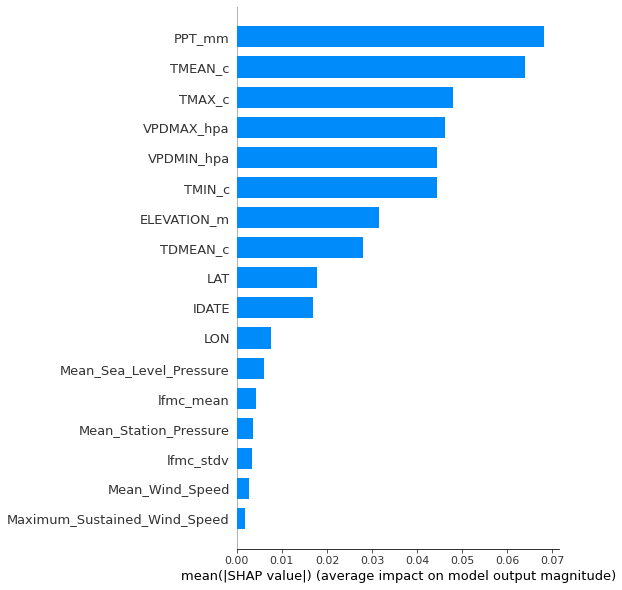

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample, plot_type="bar")

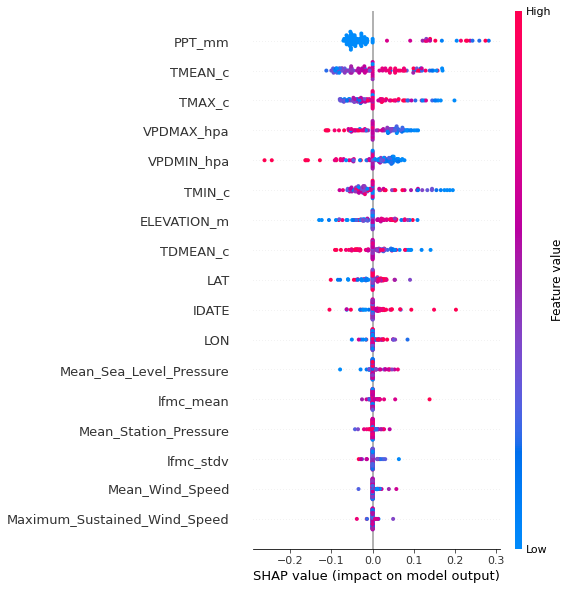

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample)

In [ ]:
shap.initjs()
shap.force_plot(k_explainer.expected_value, k_shap_values, X_test_sample)

In [ ]:
feature_names = X_train.columns
rf_resultX = pd.DataFrame(k_shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
#shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
0,IDATE,0.016885
1,LAT,0.017709
2,LON,0.007540
3,ELEVATION_m,0.031649
4,PPT_mm,0.068197
5,TMIN_c,0.044325
6,TMEAN_c,0.063902
7,TMAX_c,0.047891
8,TDMEAN_c,0.028054
9,lfmc_mean,0.004232
